In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("C:\LAB\Coding\Python\MODULES")
from pylab import *

In [3]:
from scalarmodesolver import scalarmodeEigsSolver
from custom_plotting import complexToRGB
from mode_generation_core_library import ComputeAllLGmodes_list, graded_index_fiber_coefs

In [5]:
save_figures_flag = False


# set up parameters:

In [82]:
#Wavelength of operation
wav = 1.55e-6
#grid:
N = 256
d_MAX = 125e-6 #cladding diameter
AN = d_MAX / N #step size
#number of modes to compute
K = 45

# Step index fibre

In [83]:

#Step index fibre parameters:
NA = 0.22
d_step = 50e-6 #fibre diameter
n_core = 1.4585 #pure silica


#calculate stuff:
k0 = 2*pi/wav
r_max = d_MAX / 2 #radiums cladding
r_step = d_step / 2 #radious core
n_cladding = sqrt(n_core**2 - NA**2)

print(f'core n = {n_core}, cladding n = {n_cladding}')
print(f'resolution: {AN * 1e6} um')


core n = 1.4585, cladding n = 1.4418121410225395
resolution: 0.48828125 um


## Build refractive profile

Number of modes supported:  248


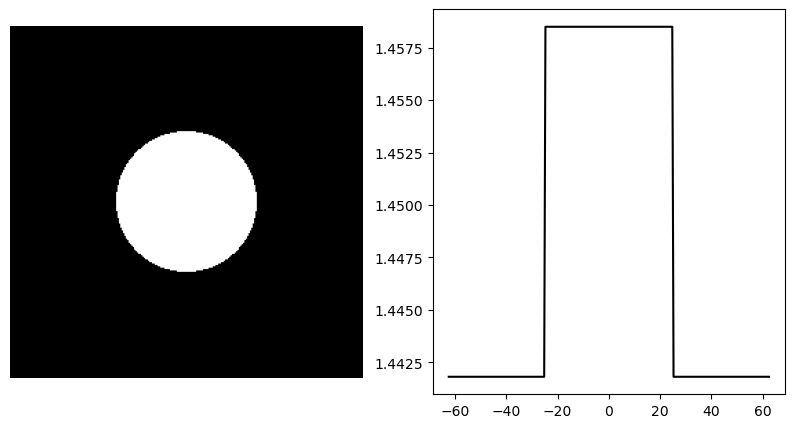

In [137]:
#make the fibre profile
x = linspace(-N//2, N//2, N) * AN #skip 0
#x = arange(-N//2, N//2) * AN # sample
X,Y = meshgrid (x,x)
R = sqrt(X**2 + Y**2)

n_step = zeros_like(R) + n_cladding
n_step[R<r_step] = n_core

f, ax = subplots(1,2, figsize = (10,5))

ax[0].imshow(n_step, cmap = 'gray')
ax[0].set_axis_off()

ax[1].plot(x*1e6, n_step[N//2,:], 'black')

#number of modes
V = k0 * r_step * NA
M = V**2 / 2
print('Number of modes supported: ', int(M))

if save_figures_flag == True:
    savefig(f'figures/step_profile.png',dpi = 300,
                bbox_inches = 'tight', transparent = True)

## Solve wave equation with n_step boundary conditions:

In [86]:
beta_step, modes_step, sm_step, sigma_step = scalarmodeEigsSolver(n = n_step, dx = AN, dy = AN + 1e-11, k0 = k0, xx = X,  K = 45) 
modes_step = flip(modes_step, axis = 0)
beta_step = flip(beta_step)

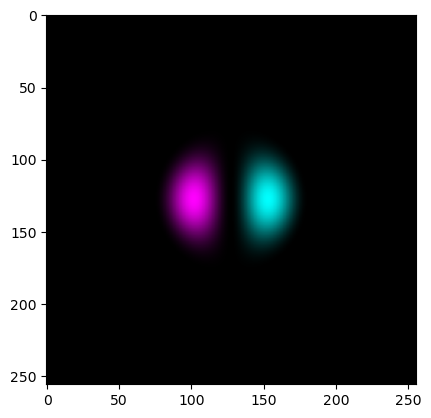

In [87]:
plt.imshow(complexToRGB(modes_step[2,...])**2)


\Delta_{n} =  0.012428142476227366


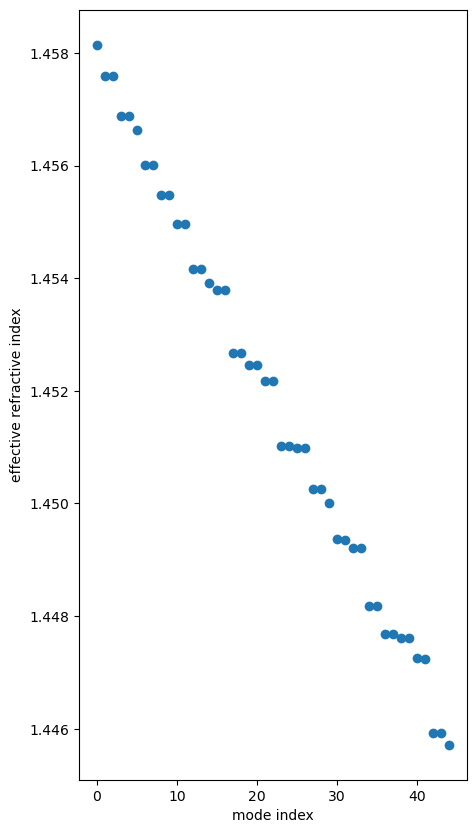

In [88]:
plt.figure(figsize = (5,10))

beta_step_norm = beta_step / sigma_step * n_core
plt.plot(beta_step_norm[:] , 'o')
plt.xlabel('mode index')
plt.ylabel('effective refractive index')
An = beta_step_norm.max() - beta_step_norm.min()
print(r'\Delta_{n} = ', f'{An}')

# Graded Index Fibre as $n = n_1 * \sqrt{1-2*\Delta * {(\frac{R}{r_{core}})}^{\alpha}}$ with $\Delta \approx \frac{n1-n2}{n1}$ and $\alpha = 2$

In [89]:
#Graded index fibre
n1 = 1.49 #max refractive index
n2 = 1.46 #min refractive index
d_GI = 62.5e-6

## Build refractive index profile

Delta 0.020134228187919483
Number of modes supported:  358


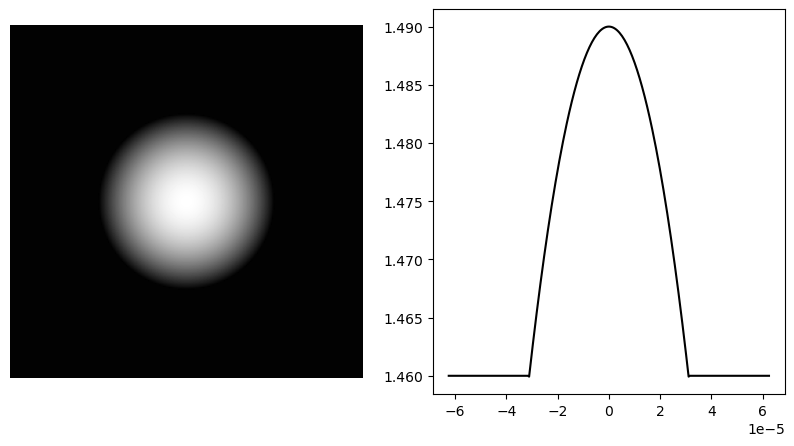

In [181]:
r_GI = d_GI/2
Delta = (n1 - n2) / n1 #approx
print(f'Delta {Delta}')
alpha = 2
n_GI = n1 * sqrt(1 - 2*Delta * (R/r_GI)**alpha )
n_GI[R>r_GI] = n2

f, ax = subplots(1,2, figsize = (10,5))

ax[0].imshow(n_GI, cmap = 'gray')
ax[0].set_axis_off()

ax[1].plot(x, n_GI[N//2,:], 'black')

#number of modes
V_GI = k0 * r_GI * n1 * sqrt(2*Delta)
M_GI = V_GI**2 / 4
print('Number of modes supported: ', int(M_GI))

if save_figures_flag == True:
    savefig(f'figures/GI_profile.png',dpi = 300,
                   bbox_inches = 'tight', transparent = True)

In [191]:
beta_GI, modes_GI, sm_GI, sigma_GI = scalarmodeEigsSolver(n = n_GI, dx = AN, dy = AN + 1e-13, k0 = k0, xx = X,  K = K) 
modes_GI = flip(modes_GI, axis = 0)
beta_GI = flip(beta_GI)

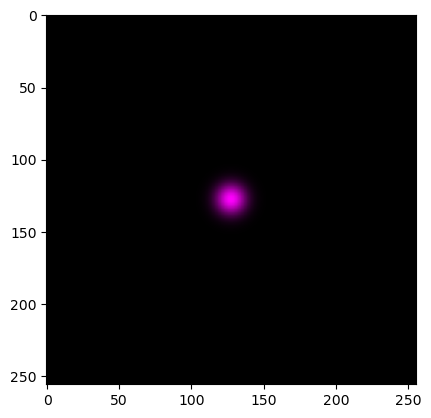

In [192]:
plt.imshow(complexToRGB(modes_GI[0,...])**2)


$\Delta_{n}$ =  0.02537119691818024


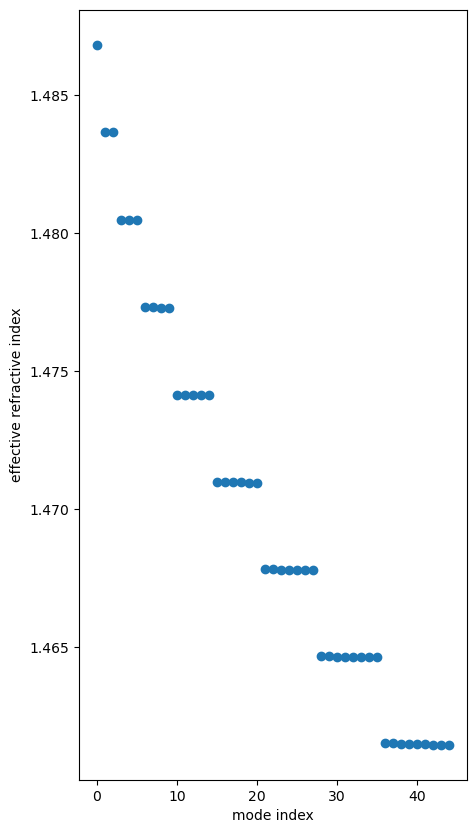

In [93]:
plt.figure(figsize = (5,10))
beta_GI_norm = beta_GI / sigma_GI * n1
plt.plot(beta_GI_norm,'o')
plt.xlabel('mode index')
plt.ylabel('effective refractive index')
An = beta_GI_norm.max() - beta_GI_norm.min()
print(r'$\Delta_{n}$ = ', f'{An}')

# Compact all the results in some nice figures:

## Step Index FIGURE ->

In [18]:
from scipy.special import jn_zeros

In [19]:
# Get all Bessels function zeros to sort the LP_lm indexes
nn = K
zeros_jn = zeros((nn,nn))
for i in range(nn):
    zeros_jn[:,i] = jn_zeros(i, nn)
    
LP_index = sort(zeros_jn.flatten())
j = unravel_index(argsort(zeros_jn, axis = None), zeros_jn.shape)
j = array(j)
j.shape

(2, 2025)

In [20]:
j = unravel_index(argsort(zeros_jn, axis = None), zeros_jn.shape)
j = array(j)

In [21]:
def compute_all_index ( LGmodes, indexes, make_negative = False):
    """
    Computes the comlex conjugate of the LGmodes if it is needed.
    
    - LGmodes matrix (Modes,X,Y).
    - Index of the half piramid, from LGindexes(modeGroup)function.
    """
    WholeModesSet = []
    
    if make_negative == True:
        LGmodesConjugate = LGmodes * -1
    else:
        LGmodesConjugate = LGmodes
        
    #LGmn modes --> Unique modes n = 0
    n = indexes[1,:]
    for count,n_idx in enumerate(n):
        if (n_idx == 0):
            #Independent mode
            WholeModesSet.append(LGmodes[count,...])
        else:
            #Pair of modes
            WholeModesSet.append(LGmodes[count,...])
            WholeModesSet.append(LGmodesConjugate[count,...])
            
    #Done for Loop        
    return((WholeModesSet))

In [22]:
whole_index_0 = compute_all_index(j[0],j)
whole_index_1 = compute_all_index(j[1],j, make_negative=True)
whole_index_2 = compute_all_index(j[1],j, make_negative=False)

LP_index_all = array([array(whole_index_0), array(whole_index_1)]) #unfold the left side of the piramid with the degerated modes
LP_index_all_ = array([array(whole_index_0), array(whole_index_2)]) #folded piramid


In [23]:
print(LP_index_all[0, 0:45])
print(LP_index_all[1, 0:45])

[0 0 0 0 0 1 0 0 1 1 0 0 1 1 2 0 0 1 1 0 0 2 2 1 1 0 0 2 2 3 0 0 1 1 2 2 3
 3 0 0 1 1 2 2 0]
[ 0  1 -1  2 -2  0  3 -3  1 -1  4 -4  2 -2  0  5 -5  3 -3  6 -6  1 -1  4
 -4  7 -7  2 -2  0  8 -8  5 -5  3 -3  1 -1  9 -9  6 -6  4 -4 10]


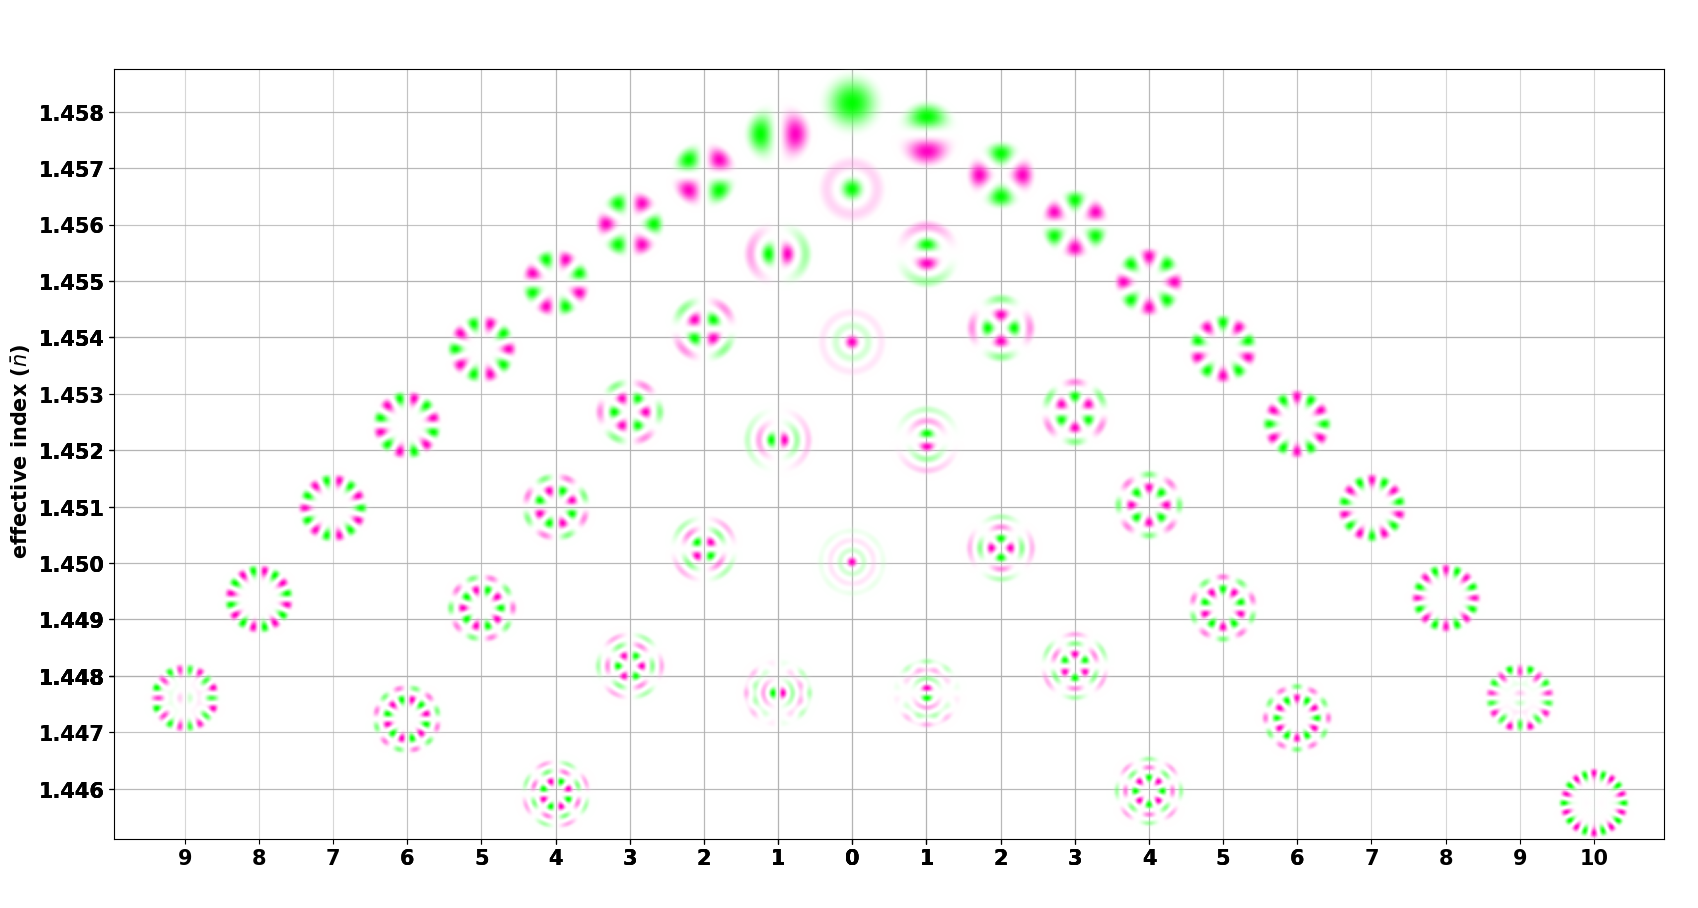

In [24]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import FormatStrFormatter

l = LP_index_all[1,:K] #azimuthal index
y = beta_step_norm
ylabel = []
for i in y:
    ylabel.append(round(i,3))
    
yaxis = array(ylabel)

ajust_phase = -0.8
def getImage(path, zoom=0.5):
    return OffsetImage(complexToRGB(path * exp(1j* ajust_phase), background = 'white', transparency='on'), zoom=zoom)

fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(l, y, s = 1, alpha = 0, marker = '*' , color = 'black')
ax.grid(True, alpha = 0.5)   

x_labels = abs(l)
    
ax.set_xticks(l, x_labels, fontweight='bold', fontsize='15')  
ax.set_yticks(yaxis, ylabel, fontweight='bold', fontsize='15')  
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

#ax.set_xlabel(r' $\it{l}$ index ', fontsize='15', fontweight='bold', loc='center')
ax.set_ylabel(r' effective index ($\bar{n}$) ', fontsize='15', fontweight='bold')


for l0, n0, mode in zip(l, y, modes_step):
    ab = AnnotationBbox(getImage(mode), (l0, n0), frameon=False)
    ax.add_artist(ab)

if save_figures_flag == True:    
    savefig(f'figures/step_results.png',dpi = 600,
                   bbox_inches = 'tight', transparent = False)

## GI Fibre FIGURE

In [25]:

index = graded_index_fiber_coefs(9) #This function takes mode group so it is hard coded - 45 modes = 9 mode groups
whole_index_0 = compute_all_index(index[0], index, make_negative = False)
whole_index_1 = compute_all_index(index[1], index, make_negative = True) 
GI_index_all = array([array(whole_index_0), array(whole_index_1)]).astype(int)
#print(GI_index_all)


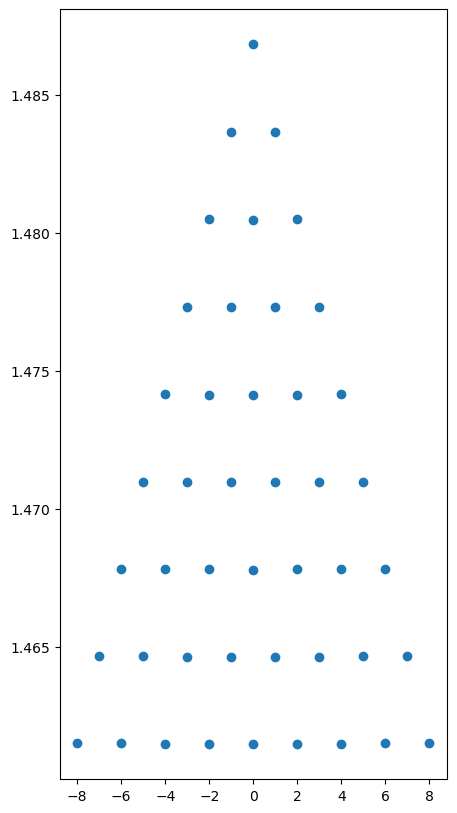

In [26]:
figure(figsize = (5,10))
plot(GI_index_all[1], beta_GI_norm, 'o')

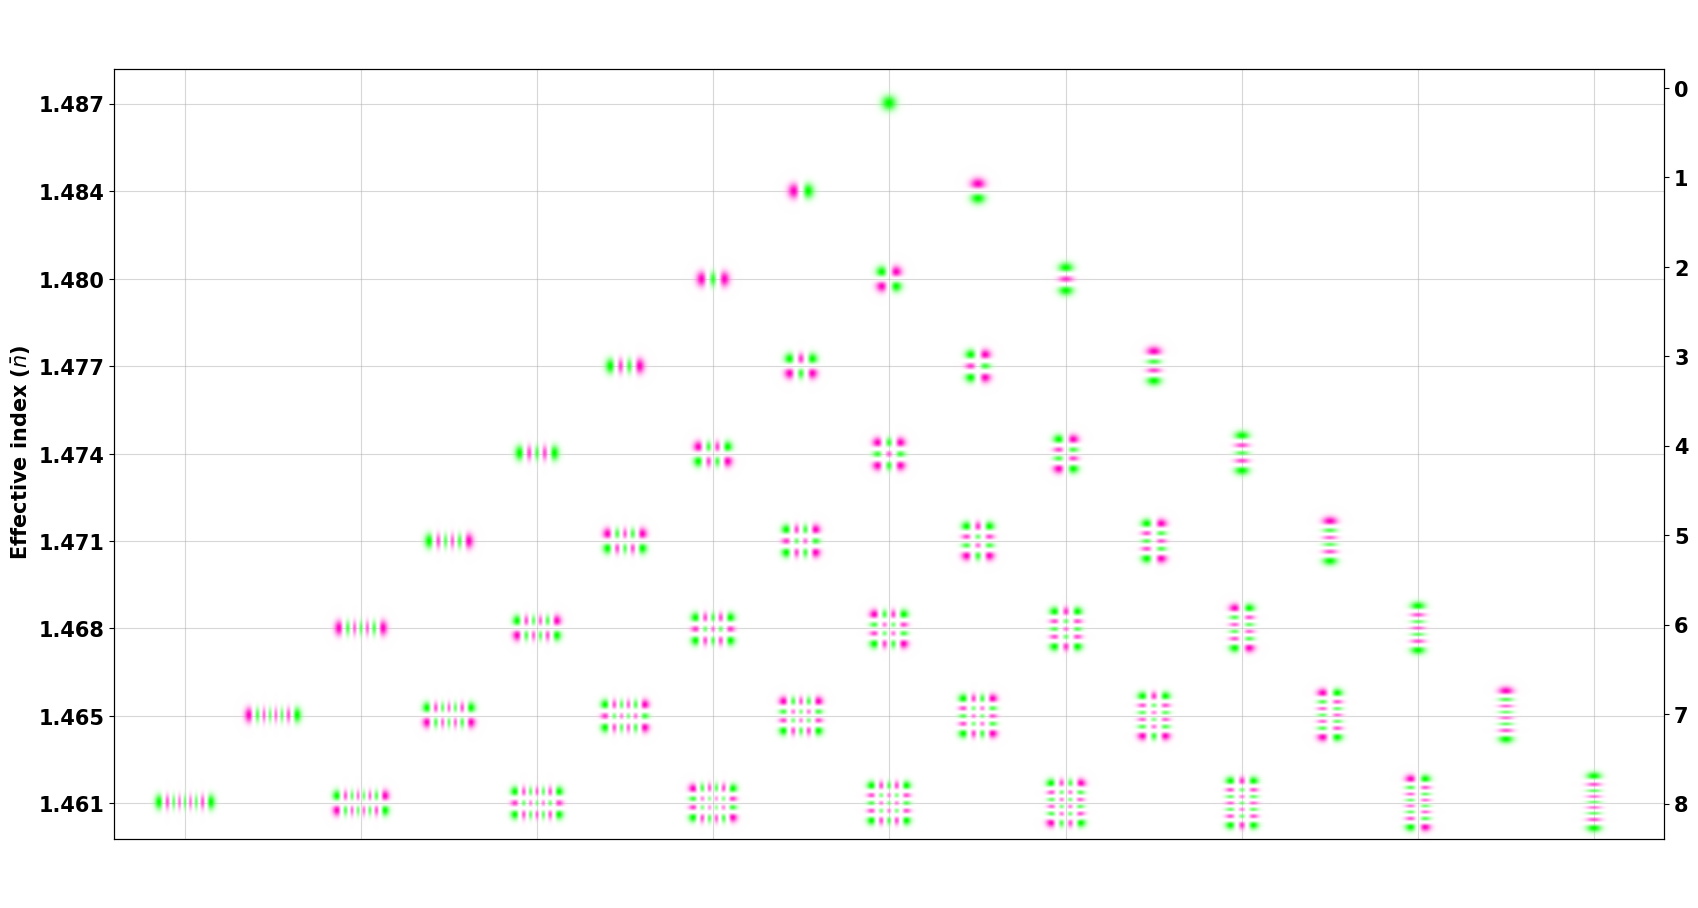

In [117]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import FormatStrFormatter


l = GI_index_all[1,:] #y zeros cuts - X-axis basicly
y = beta_GI_norm

#Average de propagation constant of each mode group to added to the yticks
beta_GI_av = []
cnt = 0
for i in range(1,10):
    btAV = average(beta_GI_norm[cnt: (cnt+i) ])
    beta_GI_av.append( btAV )
    cnt = cnt + i 

#Tune y axis
ylabel = beta_GI_av
yaxis = array(ylabel)

ajust_phase = -0.8
def getImage(path, zoom=0.5):
    return OffsetImage(complexToRGB(path * exp(1j* ajust_phase), background = 'white', transparency='on'), zoom=zoom)

fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(l, y, s = 1, alpha = 0, marker = '*' , color = 'black')


#Clean xticks and do axes in illustrator - simplier or just right y axis with n+m
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are of
#ax.set_xticks(l, l, fontweight='bold', fontsize='15')   #this indixes good for piramid but are for LG 
#ax.set_yticklabels(ylabel, fontsize='15', fontweight='bold')
ax.set_yticks(yaxis, ylabel, fontweight='bold', fontsize='15')  
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


#ax.set_xlabel(r' $l$ index ', fontsize='15', fontweight='bold')
ax.set_ylabel(r' Effective index ($\bar{n}$) ', fontsize='15', fontweight='bold')

#Use the y axis from index (l + m)
y_index = (arange(y.shape[0]))
ax2 = ax.twinx()

ax2.scatter(l, y_index, s = 1, alpha = 0, marker = '*' , color = 'black')
y_2_axis = linspace(0,y.shape[0],len(beta_GI_av))
labels = arange(8,-1,-1) #hard code modegroiup - 1
ax2.set_yticks(y_2_axis, labels, fontweight='bold', fontsize='15')  
#ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
#ax2.set_ylabel(r' $l+m$ index ', fontsize='15', fontweight='bold')

#ax2.set_ylabel(r' Propagation constand ($\beta$)', fontsize='15', fontweight='bold')

ax.grid(True, alpha = 0.5)   
# Add the modes where scatter dots
for l0, n0, mode in zip(l, y, modes_GI):
    ab = AnnotationBbox(getImage(mode), (l0, n0), frameon=False)
    ax.add_artist(ab)

if save_figures_flag == True:
    savefig(f'figures/GI_results.png',dpi = 600,
                   bbox_inches = 'tight', transparent = False)

# Mode Field Diameter discussion:

In [28]:
import laserbeamsize as lbs

In [193]:
LP01 = abs(modes_step[0,...])
LP11 = abs(modes_step[1,...])
HG00 = abs(modes_GI[0,...])

## Compare with analytical approximation formulas

In [206]:
#for multimode mode - SI
NA_SI = 0.22
d_smf = 50
wlength = 1.55
a_core = d_smf /2
V_SI = (2*pi*NA_SI * a_core) / wlength
w0_smf = a_core * (0.65 + (1.619/V_smf**1.5) + (2.879/V_SI**6))#2*wlength / (pi*NA_smf)
print(f'V number = {V_SI}, beam waist w0 = {w0_smf}, MFD = {w0_smf*2}')

V number = 22.29517367063724, beam waist w0 = 16.634477765868418, MFD = 33.268955531736836


In [207]:
# Multimode - GI
wlength = 1.55
a_GI = 62.5 / 2
V_GI = (2*pi/wlength) * a_GI * n1 * sqrt(2*Delta)
MFD_GI = sqrt(8/V_GI) * a_GI 
print(f'V number = {V_GI}, beam waist w0 = {MFD_GI/2}, MFD = {MFD_GI}')

V number = 37.876247980211176, beam waist w0 = 7.180944065287357, MFD = 14.361888130574714


In [211]:
sqrt(sqrt(2) * a_GI / (2*pi /wlength * n1 * sqrt(Delta)))

7.180944065287358

## Check the simulations MFD

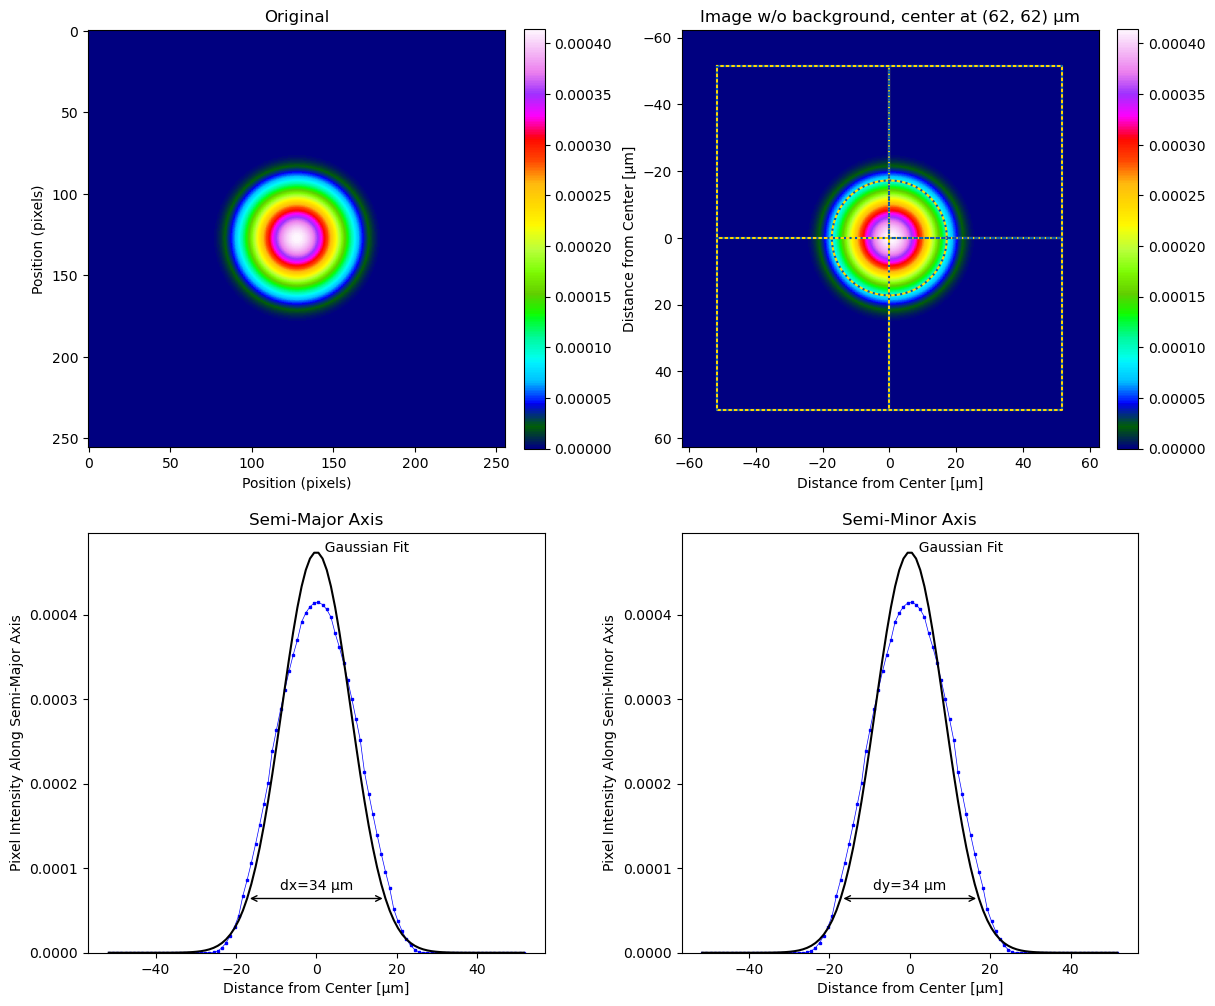

In [199]:
lbs.beam_size_plot((LP01)**2, pixel_size=AN*1e6)

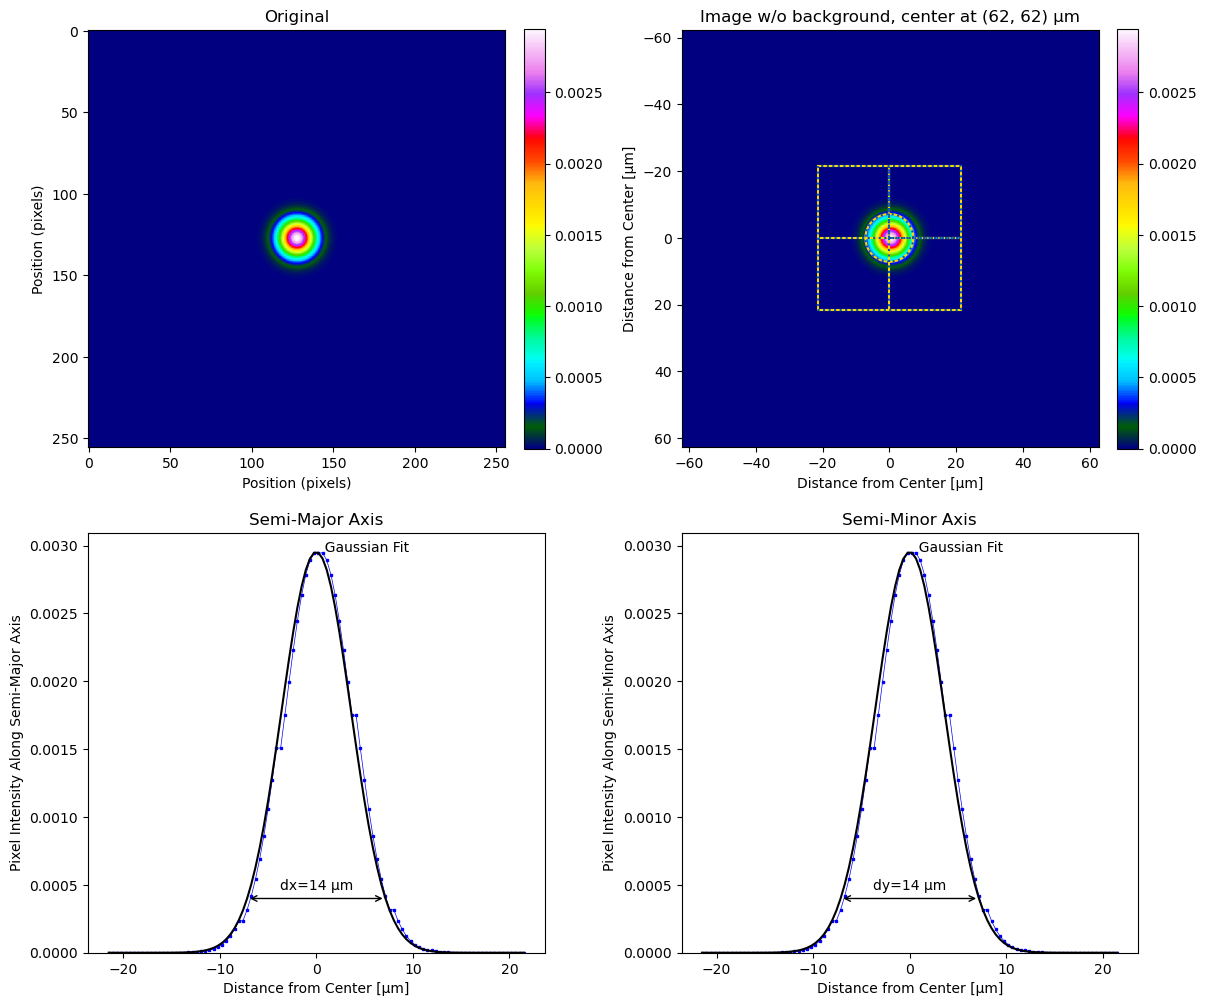

In [200]:
lbs.beam_size_plot(HG00**2, pixel_size=AN*1e6)

# Other stuff

In [30]:
Ex = modes_step[1,...]
Ey = modes_step[2,...] 
Z = sqrt(Ex**2 + Ey**2)

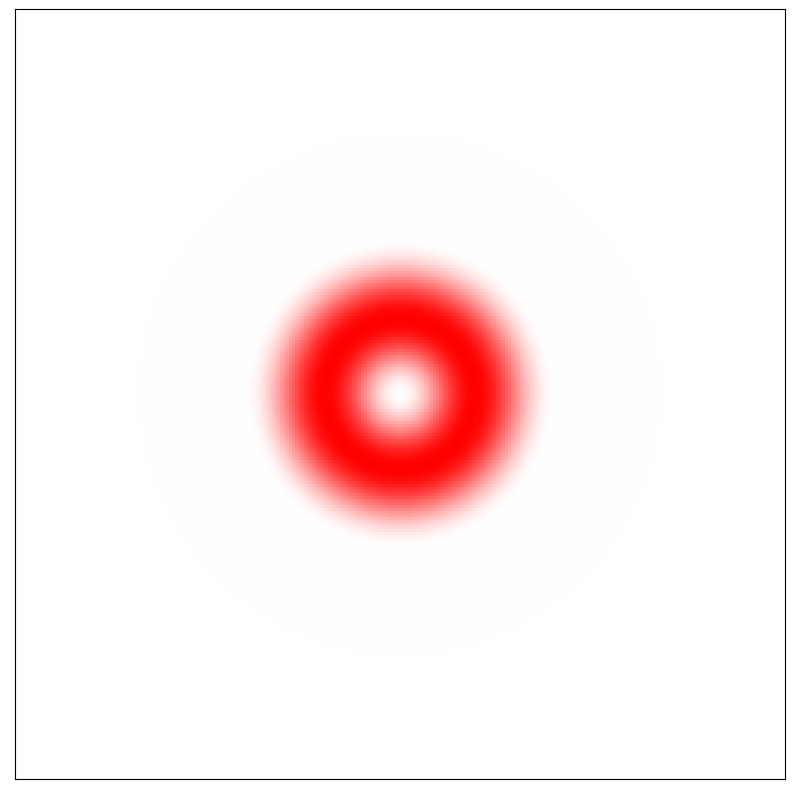

In [186]:
figure(figsize=(10,10))


fig = imshow(complexToRGB(Z,background='white', transparency=True),cmap = 'jet')

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
    
savefig(f'figures/vector_mode_amplitude.png',dpi = 600,
               bbox_inches = 'tight', transparent = True)

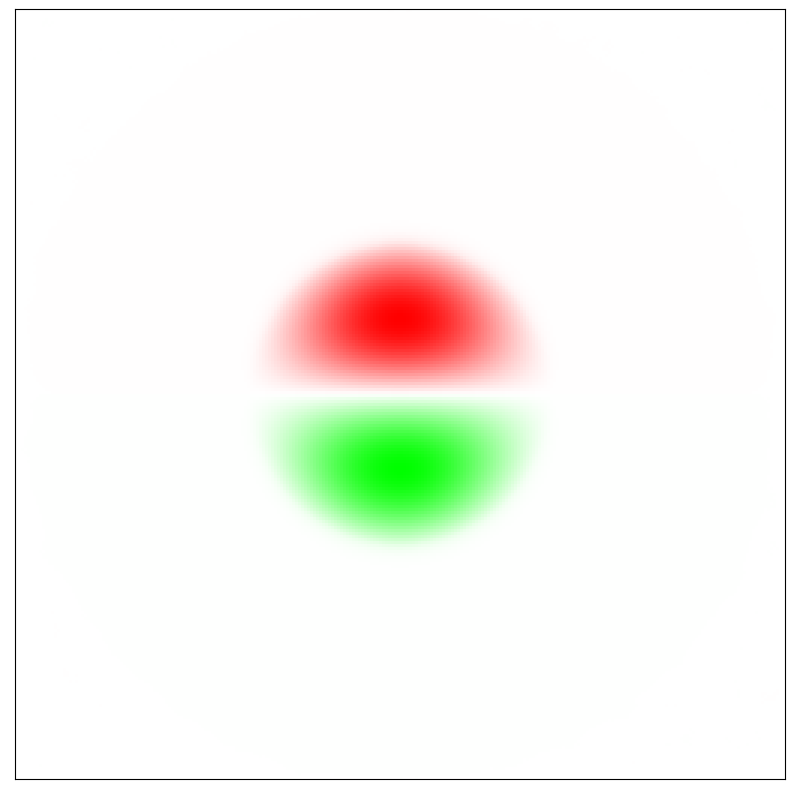

In [190]:
figure(figsize=(10,10))


fig = imshow(complexToRGB(modes_step[1,...],background='white', transparency=True),cmap = 'jet')

fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
    
savefig(f'figures/LP11a.png',dpi = 600,
               bbox_inches = 'tight', transparent = True)


In [169]:
modes_step = modes_step / sqrt(sum(abs(modes_step)**2,(1,2)))[:,None,None]

In [175]:
sum(abs(modes_step[0:5,...])**2,(1,2))

array([1., 1., 1., 1., 1.])